In [109]:
!pip install rdkit


In [110]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


In [111]:
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


In [112]:
!pip install torch-geometric

In [113]:
import torch_geometric

In [114]:
!pip install optuna

In [115]:
import torch
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
print (train_on_gpu)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')

True


In [116]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
import math
import os
import matplotlib.pyplot as plt
import string

import spacy
from spacy.tokens import Doc
from spacy import displacy
from scipy.sparse import coo_matrix

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import lr_scheduler
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, TransformerConv, GATv2Conv, ChebConv, ResGatedGraphConv
import torch_geometric.nn as pyg_nn
from torch_geometric.loader import DataLoader

In [117]:
!pip install optuna

In [118]:
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

In [119]:
# open the molecule data
import pandas as pd
df = pd.read_csv("/kaggle/input/molecular-dataset/molecular_data.csv")
df.head()

,Number of Atoms,CSD_Label,Atom,X,Y,Z
0,77,CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...,Ir,5.830300,3.029099,16.717265
1,77,CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...,O,4.591596,4.113017,15.213939
2,77,CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...,O,4.102707,3.441509,18.051009
3,77,CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...,N,6.651509,4.646264,17.527821
4,77,CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...,N,5.003926,1.431850,15.851927


In [120]:
# open SMILES data
smiles = pd.read_csv("/kaggle/input/moleculardataset/input_smiles.csv")
smiles.head()

,atoms,SMILES,CSD_code,q,S,Stoichiometry,MND
0,116,[La]1(N(c2c(cccc2C(C)C)C(C)C)[C](N1c1c(cccc1C(...,WIXKOE,0,0,C47H65LaN2O,7
1,42,[Sc]123(ON(O1)[O])(ON([O])O2)ON([O])O3.n1ccccc...,DUCVIG,0,0,C13H10N9O9Sc,8
2,73,[La]123(O[C](C=C(O1)C(F)(F)F)C(F)(F)F)(OC(=C[C...,KINJOG,0,0,C23H21F18LaO10,10
3,46,[Sc]123(OC(=C[C](O1)C(F)(F)F)C(F)(F)F)(O[C](C(...,GEKYEC,0,0,C15H5F18O7Sc,7
4,72,n1([Y][C@@]2([C](C(=C([C]2C)C)C)C)C)c(c(c(c1C)...,PIBNEV,0,0,C28H42NY,11


[La]123(O[C](C=C(O1)C(F)(F)F)C(F)(F)F)(OC(=C[C](O2)C(F)(F)F)C(F)(F)F)O[C](C=C(O3)C(F)(F)F)C(F)(F)F.O(C)CCOCCOCCOC


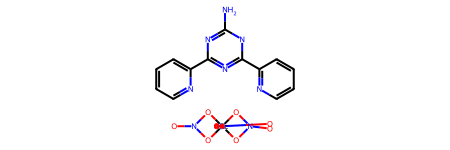

In [121]:
smiles_list = smiles['SMILES'].tolist()
mol = Chem.MolFromSmiles(smiles_list[1],sanitize=False)
print (smiles_list[2])
mol

In [122]:
# Open property data
prop = pd.read_csv("/kaggle/input/molecular-dataset/new_quality.csv")

In [123]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """
    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding

In [124]:
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

In [125]:
def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

In [126]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles, sanitize = True)
        if mol is not None:
            # get feature dimensions
            n_nodes = mol.GetNumAtoms()
            n_edges = 2*mol.GetNumBonds()
            unrelated_smiles = "O=O"
            unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
            n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
            n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

            # construct node feature matrix X of shape (n_nodes, n_node_features)
            X = np.zeros((n_nodes, n_node_features))

            for atom in mol.GetAtoms():
                X[atom.GetIdx(), :] = get_atom_features(atom)
                
            X = torch.tensor(X, dtype = torch.float)
            
            # construct edge index array E of shape (2, n_edges)
            (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
            torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
            torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
            E = torch.stack([torch_rows, torch_cols], dim = 0)
            
            # construct edge feature array EF of shape (n_edges, n_edge_features)
            EF = np.zeros((n_edges, n_edge_features))
            
            for (k, (i,j)) in enumerate(zip(rows, cols)):
                
                EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
            
            EF = torch.tensor(EF, dtype = torch.float)
            
            # construct label tensor
            y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
            
            # construct Pytorch Geometric data object and append to data list
            data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

In [127]:
# Check if SMILES string is valid in entire dataset and filter out invalid SMILES Strings and associated labels from quality

def check_smiles_validity(smiles):
    """
    Takes a SMILES string as input and returns True if the SMILES string is valid and False otherwise.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize = False)
    if mol is None:
        return False
    else:
        True

# check if SMILES string is valid in entire dataset and filter out invalid SMILES Strings 

smiles['Valid'] = smiles['SMILES'].apply(lambda x: check_smiles_validity(x))

In [128]:
smiles.Valid.value_counts()

Series([], Name: Valid, dtype: int64)

In [129]:
prop['SMILES'] = smiles['SMILES']
prop.head()

prop_valid = prop['SMILES'].apply(check_smiles_validity)

In [130]:
# canonical training loop for a Pytorch Geometric GNN model gnn_model

# create list of molecular graph objects from list of SMILES x_smiles and list of labels y
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(smiles['SMILES'].tolist(), prop['HL_Gap'].tolist())

[04:16:02] Explicit valence for atom # 20 N, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 1 N, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 3 N, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 1 N, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 24 B, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 1 N, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 10 N, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 0 B, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 22 B, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 6 B, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 1 N, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 8 N, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 8 N, 4, is greater than permitted
[04:16:02] Explicit valence for atom # 30 N, 4,

In [131]:
len(data_list)

70263

In [132]:
from torch.utils.data import random_split
from torch_geometric.data import DataLoader
train_set, valid_set, test_set = random_split(
    data_list,[40000, 20000, 10263])
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

/opt/conda/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



In [133]:
# If you have cuda, do the following
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [134]:
# Build graph neural network using pytocrch geometric on graph data

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(79, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 16)
        self.conv4 = GCNConv(16, 8)
        self.fc1 = Linear(8, 4)
        self.fc2 = Linear(4, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = global_mean_pool(x, data.batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

model = GNN()
model.to(device)

GNN(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 32)
  (conv3): GCNConv(32, 16)
  (conv4): GCNConv(16, 8)
  (fc1): Linear(in_features=8, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)

In [179]:
import torch.nn as nn

# define loss function
loss_function = nn.MSELoss()

# define optimiser
optimiser = torch.optim.SGD(model.parameters(), lr =0.004415575978781961)

# loop over 10 training epochs
for epoch in range(10):
        running_loss = 0
        val_running_loss = 0
        # set model to training mode
        model.train()
    
        # loop over minibatches for training
        for (k, batch) in enumerate(trainloader):

            batch = batch.to(device)
            # compute current value of loss function via forward pass
            output = model(batch)
            output = output.to(device)
            loss_function_value = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))
    
            # set past gradient to zero
            optimiser.zero_grad()
    
            # compute current gradient via backward pass
            loss_function_value.backward()

            running_loss += loss_function_value.item()
    
            # update model weights using gradient and optimisation method
            optimiser.step()

        avg_loss = running_loss / len(trainloader)
        # Print training loss
        print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch,avg_loss))

        for (k, batch) in enumerate(validloader):
          batch = batch.to(device)
          output = model(batch)
          output = output.to(device)
          val_loss = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))    
          val_running_loss += val_loss.item()
        
        avg_val_loss = val_running_loss / len(validloader)

        print ('Epoch: {:03d}, Validation Loss: {:.5f}'.format(epoch,avg_val_loss))  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch: 000, Loss: 0.00094


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch: 000, Validation Loss: 0.00094
Epoch: 001, Loss: 0.00094
Epoch: 001, Validation Loss: 0.00095
Epoch: 002, Loss: 0.00094
Epoch: 002, Validation Loss: 0.00094
Epoch: 003, Loss: 0.00095
Epoch: 003, Validation Loss: 0.00095
Epoch: 004, Loss: 0.00095
Epoch: 004, Validation Loss: 0.00095
Epoch: 005, Loss: 0.00094
Epoch: 005, Validation Loss: 0.00095
Epoch: 006, Loss: 0.00094
Epoch: 006, Validation Loss: 0.00094
Epoch: 007, Loss: 0.00094
Epoch: 007, Validation Loss: 0.00094
Epoch: 008, Loss: 0.00094
Epoch: 008, Validation Loss: 0.00095
Epoch: 009, Loss: 0.00094
Epoch: 009, Validation Loss: 0.00094


In [160]:
# Evaluate model on test set

def evaluate(model, loader):
    model.eval()
    error = 0
    for data in loader:
        data = data.to(device)
        pred = model(data)
        pred = pred.to(device)
        error += loss_function(pred, data.y).item()
    return error / len(loader)

print('Test Error: {:.4f}'.format(evaluate(model, testloader)))

Test Error: 0.0011


0.0011307216614609543


(array([[0.11407769],
        [0.08617643],
        [0.10018303],
        ...,
        [0.11314657],
        [0.11407769],
        [0.11315577]], dtype=float32),
 array([0.12289, 0.05935, 0.06218, ..., 0.10895, 0.09289, 0.11263],
       dtype=float32))

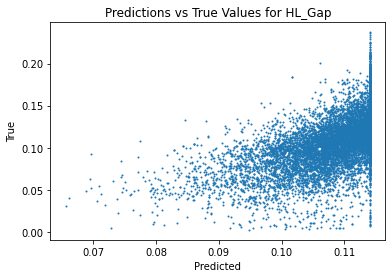

In [182]:
## Plot predictions against true values

import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    error = 0
    for i,data in enumerate(loader):
        data = data.to(device)
        pred = model(data)
        pred = pred.to(device)
        y_pred.append(pred.cpu().detach().numpy())
        y_true.append(data.y.cpu().detach().numpy())
        error += loss_function(pred, data.y).item()
    y_pred = list(np.array(y_pred,dtype=object).flatten())
    y_true = list(np.array(y_true,dtype=object).flatten())
    
    # Concatenate list of numpy arrays across axis 0
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    
    print (error/len(loader))
    # Plot predictions against true values
    plt.scatter(y_pred, y_true, s=1)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Predictions vs True Values for HL_Gap')

    return y_pred, y_true
plot_predictions(model, testloader)

Optuna Hyperparamter Tuning

In [162]:
import optuna
import torch.optim as optim

In [171]:
def objective(trial):

    model = GNN()
    model.to(device)

    # Generate the optimizers
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    #layers = trial.suggest_int('layers', 1, 3)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    criterion = nn.MSELoss()

    optimiser = torch.optim.Adam(model.parameters(), lr = 1e-3)

    # loop over 10 training epochs
    for epoch in range(10):
            running_loss = 0
            val_running_loss = 0
            # set model to training mode
            model.train()
        
            # loop over minibatches for training
            for (k, batch) in enumerate(trainloader):
        
                # compute current value of loss function via forward pass
                batch = batch.to(device)
                output = model(batch)
                output = output.to(device)
                loss_function_value = criterion(output[:,0], torch.tensor(batch.y, dtype = torch.float32))
                # set past gradient to zero
                optimiser.zero_grad()

                running_loss += loss_function_value.item()
        
                # compute current gradient via backward pass
                loss_function_value.backward()
        
                # update model weights using gradient and optimisation method
                optimiser.step()

            avg_loss = running_loss / len(trainloader)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            for (k, batch) in enumerate(validloader):
              batch = batch.to(device)
              output = model(batch)
              output = output.to(device)
              val_loss = criterion(output[:,0], torch.tensor(batch.y, dtype = torch.float32))    
              val_running_loss += val_loss.item()
          
            avg_val_loss = val_running_loss / len(validloader)
            trial.report(avg_val_loss, epoch)

            print ('Epoch: {:03d}, Validation Loss: {:.5f}'.format(epoch,avg_val_loss))   

    return avg_val_loss

In [172]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

trial = study.best_trial
print ('Best trial: score {},\nparams {}'.format(trial.value, trial.params))
print ('Best Hyperparameters: {}'.format(study.best_params))

[I 2022-12-06 05:02:50,171] A new study created in memory with name: no-name-594f3b3d-0d38-4e69-9e79-f7cb7ccc578f
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch: 000, Validation Loss: 0.00100
Epoch: 001, Validation Loss: 0.00094
Epoch: 002, Validation Loss: 0.00094
Epoch: 003, Validation Loss: 0.00094
Epoch: 004, Validation Loss: 0.00094
Epoch: 005, Validation Loss: 0.00092
Epoch: 006, Validation Loss: 0.00091
Epoch: 007, Validation Loss: 0.00091
Epoch: 008, Validation Loss: 0.00091


[I 2022-12-06 05:05:47,049] Trial 0 finished with value: 0.000901400375412777 and parameters: {'optimizer': 'SGD', 'lr': 1.3742676325325823e-05}. Best is trial 0 with value: 0.000901400375412777.


Epoch: 009, Validation Loss: 0.00090
Epoch: 000, Validation Loss: 0.00099
Epoch: 001, Validation Loss: 0.00095
Epoch: 002, Validation Loss: 0.00094
Epoch: 003, Validation Loss: 0.00094
Epoch: 004, Validation Loss: 0.00094
Epoch: 005, Validation Loss: 0.00092
Epoch: 006, Validation Loss: 0.00091
Epoch: 007, Validation Loss: 0.00091
Epoch: 008, Validation Loss: 0.00091


[I 2022-12-06 05:08:41,814] Trial 1 finished with value: 0.000899083807785064 and parameters: {'optimizer': 'SGD', 'lr': 0.004415575978781961}. Best is trial 1 with value: 0.000899083807785064.


Epoch: 009, Validation Loss: 0.00090
Epoch: 000, Validation Loss: 0.00100
Epoch: 001, Validation Loss: 0.00095
Epoch: 002, Validation Loss: 0.00094
Epoch: 003, Validation Loss: 0.00094
Epoch: 004, Validation Loss: 0.00093
Epoch: 005, Validation Loss: 0.00092
Epoch: 006, Validation Loss: 0.00091
Epoch: 007, Validation Loss: 0.00091
Epoch: 008, Validation Loss: 0.00091


[I 2022-12-06 05:11:36,678] Trial 2 finished with value: 0.0009013995614368469 and parameters: {'optimizer': 'SGD', 'lr': 0.007611937172293893}. Best is trial 1 with value: 0.000899083807785064.


Epoch: 009, Validation Loss: 0.00090
Epoch: 000, Validation Loss: 0.00100
Epoch: 001, Validation Loss: 0.00095
Epoch: 002, Validation Loss: 0.00094
Epoch: 003, Validation Loss: 0.00094
Epoch: 004, Validation Loss: 0.00093
Epoch: 005, Validation Loss: 0.00092
Epoch: 006, Validation Loss: 0.00091
Epoch: 007, Validation Loss: 0.00091
Epoch: 008, Validation Loss: 0.00091


[I 2022-12-06 05:14:31,209] Trial 3 finished with value: 0.0008993665944319218 and parameters: {'optimizer': 'Adam', 'lr': 0.00012147564077710757}. Best is trial 1 with value: 0.000899083807785064.


Epoch: 009, Validation Loss: 0.00090
Epoch: 000, Validation Loss: 0.00100
Epoch: 001, Validation Loss: 0.00095
Epoch: 002, Validation Loss: 0.00094
Epoch: 003, Validation Loss: 0.00094
Epoch: 004, Validation Loss: 0.00094
Epoch: 005, Validation Loss: 0.00092
Epoch: 006, Validation Loss: 0.00091
Epoch: 007, Validation Loss: 0.00091
Epoch: 008, Validation Loss: 0.00092


[I 2022-12-06 05:17:26,325] Trial 4 finished with value: 0.0009018858747091144 and parameters: {'optimizer': 'RMSprop', 'lr': 8.06776814421787e-05}. Best is trial 1 with value: 0.000899083807785064.


Epoch: 009, Validation Loss: 0.00090
Best trial: score 0.000899083807785064,
params {'optimizer': 'SGD', 'lr': 0.004415575978781961}
Best Hyperparameters: {'optimizer': 'SGD', 'lr': 0.004415575978781961}


In [175]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [176]:
study.best_params

{'optimizer': 'SGD', 'lr': 0.004415575978781961}